### Importing libraries

In [91]:
%matplotlib notebook

import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [92]:
# Import all models and metrics

# Imputer
from sklearn.impute import SimpleImputer

# Linear models
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso, BayesianRidge, GammaRegressor

# SVM
from sklearn.svm import LinearSVR

# Tree-based models
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

# Ensemble methods
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor

# XGBoost
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error

### Modeling

Now that we have finished exploring the data, we have a good idea of the nuances of our dataset and which variables we want to use to predict car price.

In [93]:
mdf = pd.read_csv('data/modeling_data.csv')
mdf.columns

Index(['km', 'engine_cc', 'price', 'seats', 'num_doors', 'dim',
       'registration_year', 'sedan', 'minivan', 'truck', 'SUV', 'hatchback',
       'convertible', 'coupe', 'mini_vehicle', 'Manual', 'Automatic', 'Cvt',
       '2WD', '4WD', 'Petrol', 'Diesel', 'Hybrid'],
      dtype='object')

### Choosing the Best Model

We will be performing 10-fold cross validation and imputing missing values at each fold. The model with the best average RSME after 10 folds will be chosen as the best model. 

We have chosen RSME as the error metric for chosing the best model because it gives higher weight to larger errors, unlike MAE or MAPE. Our client is planning to use this model to estimate future costs, so it is important we eliminate models that have too large of errors and could severely underestimate future costs. MAE and MAPE will still be calculated for gaining a better understanding of model performance but will not be used for choosing the best-performing model.


Additionally, we will not be considering interpretability when choosing models. Our client has informed us that they simply want the best performing model and do not care much about knowing how much each variable affects our predictions. In other words, we will most likely not be choosing a simpler modeling algorithm, such as linear regression, because it is more interpretable than an ensemble modeling algorithm like Random Forests.

Before we can choose the best model, we need to create functions that will help us perform n-fold cross validation.

In [94]:
# Function that imputes missing values in a dataframe using the mean of each column
def impute(df, imputer):
    
    # Impute missing vals
    imputed_df = pd.DataFrame(imputer.fit_transform(df))
    imputed_df.columns = df.columns
    imputed_df.index = df.index
    
    return imputed_df

# Function that splits a dataframe into 80/20 train and test sets
def get_split(df):
    
    # Get predictors
    X = df.drop('price', axis=1)
    
    # Get target variable
    y = df.price
    
    # Split data 80/20
    Xtrain, Xtest, ytrain, ytest = sklearn.model_selection.train_test_split(X, y, test_size=0.2)
    
    # Create Imputer object
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    # Fill missing values for predictors
    Xtrain = impute(Xtrain, imp_mean)
    Xtest = impute(Xtest, imp_mean)
    
    return Xtrain, Xtest, ytrain, ytest

def baseline_model(train, Xtest):
    
    # List of all body types in dataset
    body_types = ['sedan', 'minivan', 'truck', 'SUV', 'hatchback',
       'convertible', 'coupe', 'mini_vehicle']
    
    # Initialize price column
    Xtest['price'] = 0
    
    # Calculate average price for each body type
    for body_type in body_types:
        
        # Calculate mean for a body type
        body_mean = train[train[body_type]==1]['price'].mean()
        
        # Set average as predction in test set
        Xtest.loc[Xtest[body_type] == 1, 'price'] = body_mean
    
    return Xtest.price
        

# Function that performs n-fold cross validations for a single model and
# Calculates error metrics for each fold
def cross_validate(df, m=None, n=10):
    
    # Dictionary with error metrics
    metric_dict = {'MAE': [], 'MAPE': [], 'RSME': []}
    
    for fold in range(n):
        
        # Split data for current fold
        X_train, X_test, y_train, y_test = get_split(df)
        
        # Baseline model
        if m is None:
            
            X_train['price'] = y_train
            
            y_pred = baseline_model(X_train, X_test)
        
        # fit non-baseline models
        else:
            m.fit(X_train, y_train)
        
            # predict test
            y_pred = m.predict(X_test)
        
        
        # Calculate metrics
        metric_dict['MAE'].append(mean_absolute_error(y_test, y_pred))
        
        metric_dict['MAPE'].append(np.mean(np.absolute(y_test - y_pred) / y_test))
        
        metric_dict['RSME'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
        
    return metric_dict

# Function that performs n-fold cross validations for an ensemble model and
# Calculates error metrics for each fold
def cross_validate_ensemble(df, m_list, n=10):
    
    # Dictionary with error metrics
    metric_dict = {'MAE': [], 'MAPE': [], 'RSME': []}
    
    for fold in range(n):
        
        # Split data for current fold
        X_train, X_test, y_train, y_test = get_split(df)
        
        y_preds = []
        for m in m_list:
            # fit model
            m.fit(X_train, y_train)
        
            # predict test
            y_pred = m.predict(X_test)
            y_preds.append(y_pred)
        
        # Predictions are calculated as the average prediction of
        # all models in the ensemble
        y_pred = np.average(y_preds, axis=0)
        
        # Calculate metrics
        metric_dict['MAE'].append(mean_absolute_error(y_test, y_pred))
        
        metric_dict['MAPE'].append(np.mean(np.absolute(y_test - y_pred) / y_test))
        
        metric_dict['RSME'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
        
    return metric_dict

### Modeling Algorithms

We have chosen several different modeling algorithms to test on our dataset. Although our selection does not represent the entirety of models that are offered by the sklearn library, we have chosen a mix of linear and non-linear models that should give us an insight on how to best predict car price.

Additionaly, we will be testing a baseline model that makes predictions using a very simple method: using the average price of each `body_type` as the predicted price. Sometimes, very simple models perform just as well as very complex models, and it may not be worth implementing a model that is computationally-intensive due to lack of resources. 

In [112]:
regressors = [LinearRegression(), Ridge(), SGDRegressor(), Lasso(), BayesianRidge(), GammaRegressor(),
             LinearSVR(), DecisionTreeRegressor(), ExtraTreeRegressor(), AdaBoostRegressor(), 
              GradientBoostingRegressor(), RandomForestRegressor(), XGBRegressor()]

# Dataframe for storing all modeling results
model_res_df = pd.DataFrame({'Model': [],
                             'MAE': [],
                             'MAPE': [],
                             'RSME': []
                            })

# Generate performance results for each regressor in regressors list
for model in regressors:
    
    # 10-fold cross validation results
    current_results = cross_validate(mdf, model, 10)
    
    # Append Results to dataframe
    model_res_df = pd.concat([model_res_df,
                             pd.DataFrame({'Model': [type(model).__name__ for i in range(10)],
                                           'MAE': [i for i in current_results['MAE']],
                                           'MAPE': [i for i in current_results['MAPE']],
                                           'RSME': [i for i in current_results['RSME']]
                                          })])

# Generate performance results for ensemble model
current_results = cross_validate_ensemble(mdf, [DecisionTreeRegressor(), RandomForestRegressor(), XGBRegressor()], 10)

# Append model results to dataframe
model_res_df = pd.concat([model_res_df,
                            pd.DataFrame({'Model': ['Ensemble'] * 10,
                                          'MAE': [i for i in current_results['MAE']],
                                          'MAPE': [i for i in current_results['MAPE']],
                                          'RSME': [i for i in current_results['RSME']]
                                          })])

C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:326: RuntimeWarning: divide by zero encountered in log
  dev = 2 * (np.log(y_pred / y) + y / y_pred - 1)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:326: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (np.log(y_pred / y) + y / y_pred - 1)
C:\Users\14029\anaconda3\lib\site-packages\skle

C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:326: RuntimeWarning: divide by zero encountered in log
  dev = 2 * (np.log(y_pred / y) + y / y_pred - 1)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:326: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (np.log(y_pred / y) + y / y_pred - 1)
C:\Users\14029\anaconda3\lib\site-packages\skle

C:\Users\14029\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:323: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: overflow encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:42: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\14029\anaconda3\lib\site-packages\sklearn\

In [113]:
# Generate performance results for baseline model
current_results = cross_validate(mdf)

# Append model results to dataframe
model_res_df = pd.concat([model_res_df,
                            pd.DataFrame({'Model': ['Baseline'] * 10,
                                          'MAE': [i for i in current_results['MAE']],
                                          'MAPE': [i for i in current_results['MAPE']],
                                          'RSME': [i for i in current_results['RSME']]
                                          })])

In [110]:
model_res_df

,Model,MAE,MAPE,RSME
0,LinearRegression,10375.179255,0.593178,22078.437408
1,LinearRegression,10557.109814,0.603421,24169.768070
2,LinearRegression,10461.321199,0.597206,25839.124509
3,LinearRegression,10271.845049,0.595800,24451.170724
4,LinearRegression,10041.130726,0.605734,18160.105093
...,...,...,...,...
5,Baseline,12151.767143,0.855927,20728.963433
6,Baseline,12629.884873,0.846543,26496.905777
7,Baseline,12585.357585,0.858682,21538.272607
8,Baseline,12384.770058,0.885995,22475.294299


In [114]:
# Create dataframe with average error metrics for each model
mean_model_res = model_res_df.groupby(['Model']).mean().reset_index()

# Entries by RSME
mean_model_res.sort_values('RSME')

,Model,MAE,MAPE,RSME
11,RandomForestRegressor,4.552630e+03,2.205150e-01,1.380471e+04
14,XGBRegressor,5.213908e+03,2.641148e-01,1.555663e+04
4,Ensemble,4.605413e+03,2.206460e-01,1.594134e+04
7,GradientBoostingRegressor,6.605578e+03,3.439046e-01,1.683037e+04
3,DecisionTreeRegressor,5.396379e+03,2.558191e-01,1.927097e+04
5,ExtraTreeRegressor,6.095086e+03,2.852097e-01,1.978187e+04
8,Lasso,1.014489e+04,6.021224e-01,2.017823e+04
12,Ridge,1.023750e+04,6.030917e-01,2.045494e+04
9,LinearRegression,1.020461e+04,5.968330e-01,2.094041e+04
2,BayesianRidge,1.024769e+04,5.990556e-01,2.098388e+04


<IPython.core.display.Javascript object>


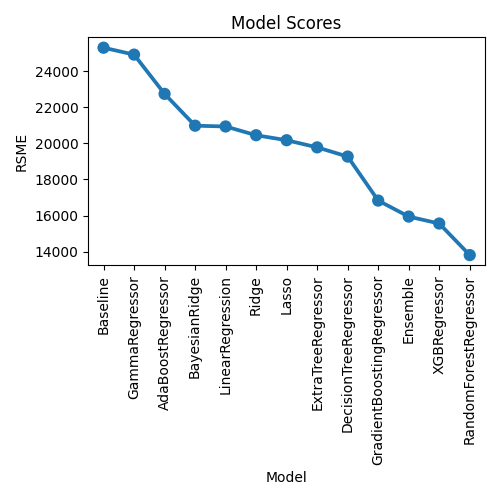

In [117]:
fig_scores_of_models = plt.figure('Model Performance',figsize=(5,5))

new_res = mean_model_res[(mean_model_res['Model'] != 'SGDRegressor') & (mean_model_res['Model'] != 'LinearSVR')]
new_res = new_res.sort_values('RSME', ascending=False)


sns.pointplot(x=new_res.Model, y=new_res.RSME, markers=['o'], linestyles=['-'])
plt.xticks(rotation=90)
plt.title('Model Scores')
plt.tight_layout()
plt.show()

### Interpreting Results

Our Random Forest outperformed all models after 10-fold cross validation since it has the lowest mean RSME value. However, the Random Forest model does have a slightly MAE and MAPE value than the Ensemble model. We suspect this is due to RSME penalizing larger errors more heavily; in other words, the Ensemble model had a lower MAE but contained larger errors which drove its RSME higher.

Also, the Random Forest model performed significantly better than our baseline, indicating that choosing a more complex model is likely worth the extra resources.

Interestingly, our Ensemble model composed of XGBoost, Decision Trees, and Random Forest came in second. This is most likely due to the errors of each model in the ensemble not being correlated with one another.

<IPython.core.display.Javascript object>


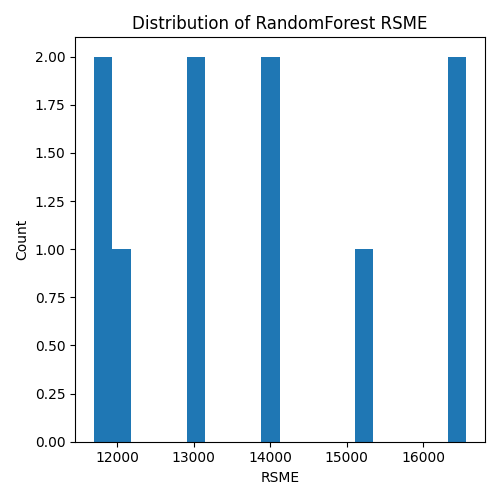

In [115]:
fig = plt.figure('Distribution of RandomForest RSME',figsize=(5,5))

plt.hist(model_res_df[model_res_df['Model']=='RandomForestRegressor'].RSME, bins=20)
plt.title('Distribution of RandomForest RSME')
plt.xlabel('RSME')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### Cross-Validation RSME Distribution


Above, we can see the distribution of the RSME for all 10 folds. 

Our average RSME was around 13,000, but you can see that for some folds we got an RSME as big as 17,000. The performance we expect from our model in production will likely be somewhere between 17,000 and 11,000 RSME.

We would likely see a normal distribution if we were to perform more than 10 folds. We could then calculate the standard deviation of our distribution and give rough estimates of how likely certain ranges of RSME values would be in production.

<IPython.core.display.Javascript object>


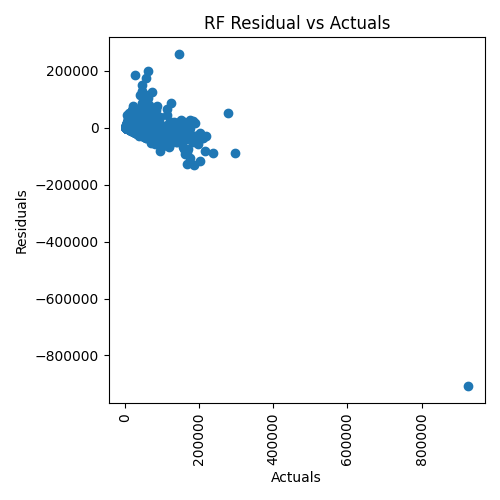

In [118]:
# Split data for current fold
X_train, X_test, y_train, y_test = get_split(mdf)

# Model
m = RandomForestRegressor()

# Fit model
m.fit(X_train, y_train)
        
# Predict test
y_pred = m.predict(X_test)

fig = plt.figure('RF Residual vs Actuals',figsize=(5,5))

plt.scatter(y_test, y_pred - y_test)
plt.title('RF Residual vs Actuals')
plt.xlabel('Actuals')
plt.ylabel('Residuals')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Residuals vs Actuals
(Not to be confused with residuals vs fitted values plot for linear models)

In general, it seems that our residuals are negatively correlated with our actuals, aside from a couple of outliers. In other words, as our actuals get bigger, we tend to more and more underprect our target variable. This especially becomes an issue when we reach extreme actuals such as \\$8M where our residuals are also around \\$8M.

In future iterations of the model we may need to break out training sets into cars of different price ranges since our model does not handle extremely expensive cars well. This means we could have a "high cost" model and a "low cost" model.

We may also want to try modeling techniques with a loss function that more heavily penalizes underestimation rather than overestimation, since our client is more concerned with the former.



<IPython.core.display.Javascript object>


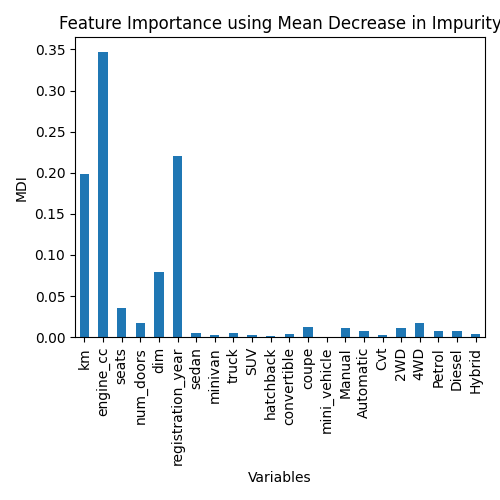

In [119]:
forest_importances = pd.Series(m.feature_importances_, index=X_train.columns)

fig_fi = plt.figure('Feature Importance using MDI',figsize=(5,5))

forest_importances.plot.bar()
plt.title('Feature Importance using Mean Decrease in Impurity')
plt.xlabel('Variables')
plt.ylabel('MDI')
plt.tight_layout()
plt.show()

### Variable Importance

We calculated the importance of each variable in the Random Forest model using Mean Decrease in Impurity (MDI). Although this method has been shown to not always be reliable, we will use it to gain a rough understanding of our variables.

Surprisingly, `body_type` did not seem to be a very important variable. This may suggest that every body type in our dataset has a broad price range. Our three most important variables were `engine _cc`, `km`, and `registration_year`, respectively. Collecting more information on engine specifications and the year the car was produced might help improve model performance.

### Final Model

We will train the RandomForest on all data and save the model for future use.

In [120]:
# Imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Train model on all data
final_model = RandomForestRegressor()

#Impute missing values on entire dataset
X_imputed = impute(mdf, imp_mean)
y = mdf.price

# Train model on entire dataset
final_model.fit(X_imputed, y)

# Write model to file
pickle.dump(final_model, open('models/JDM_RF.sav', 'wb'))